In [1]:
import numpy as np
from partition_decode.dataset import generate_gaussian_parity, load_mnist
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from partition_decode.df_utils import (
    get_tree_evals,
    get_forest_evals,
    get_forest_irm,
    get_tree_irm,
)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, zero_one_loss

In [2]:
X_train, y_train = generate_gaussian_parity(
    n_samples=100, angle_params=0, random_state=1, cov_scale=1.0
)
X_test, y_test = generate_gaussian_parity(
    n_samples=1024, angle_params=0, random_state=1234, cov_scale=1.0
)

X_train, y_train = load_mnist(
    random_state = 1,
    train=True,
    n_samples=1000,
    save_path="/mnt/ssd3/ronan/pytorch",
    onehot=True
)

X_test, y_test = load_mnist(
    random_state = 1234,
    train=False,
    n_samples=10000,
    save_path="/mnt/ssd3/ronan/pytorch",
    onehot=True
)

/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448216815/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [19]:
def get_tree_weights(tree, X):
    """Regression tree"""
    n = X.shape[0]
    leaves = tree.apply(X).reshape(n, -1) # n, 1 w/ L unique
    y_hat = tree.predict(X) # n, k
    _, indices = np.unique(leaves, axis=0, return_index=True)
    weights = np.asarray([
        np.asarray([y_hat[indices, i]]*n)
        for i in range(y_hat.shape[1])
    ])
    return weights
    
def get_forest_weights(model, X):
    tree_weights = [
        get_tree_weights(tree, X)
        for tree in model.estimators_
    ]
    return np.concatenate(tree_weights, axis=-1) / len(tree_weights)

def df(irm, p=2):
    evals = np.linalg.svd(irm, compute_uv=False)**p
    H_trace = evals.sum()
    return H_trace

def get_forest_hat_irm(irm):
    H = irm @ irm.T
    H /= np.sum(H, axis=1)
    return H

In [91]:
n_estimators = [1, 1, 1, 1, 1, 1, 5, 10, 20]
max_depths = [2, 4, 8, 16, 32, None, None, None, None, None]
gen_errors = []
irms = []
weights = []
train_errors = []
test_errors = []
for n_trees, max_depth in zip(n_estimators, max_depths):
    model = RandomForestRegressor(bootstrap=False, n_estimators=n_trees, max_depth=max_depth, n_jobs=-2, max_features=2)
    model = model.fit(X_train, y_train)
    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)
    train_errors.append(mean_squared_error(y_train, y_train_hat))
    test_errors.append(mean_squared_error(y_test, y_test_hat))
    gen_errors.append(test_errors[-1] - train_errors[-1])
    irms.append(get_forest_irm(model, X_train, scale=True))
    weights.append(get_forest_weights(model, X_train))

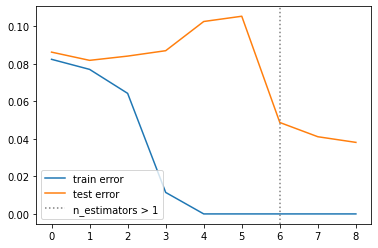

In [92]:
plt.plot(np.arange(len(train_errors)), train_errors, label='train error')
plt.plot(np.arange(len(test_errors)), test_errors, label='test error')
plt.axvline(np.argmax(np.asarray(n_estimators) > 1), ls=':', c='grey', label='n_estimators > 1')
plt.legend()
plt.show()

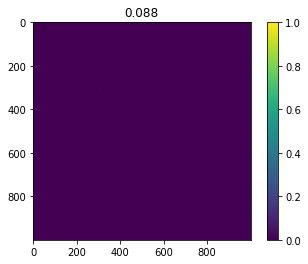

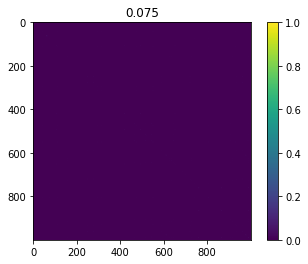

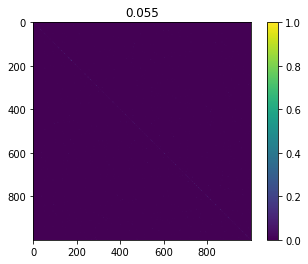

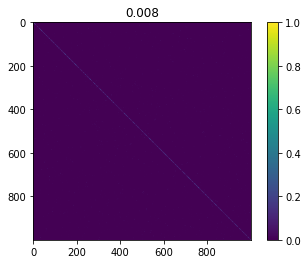

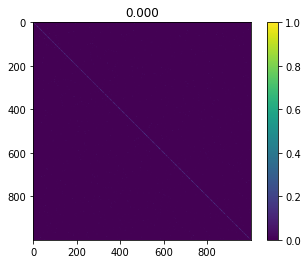

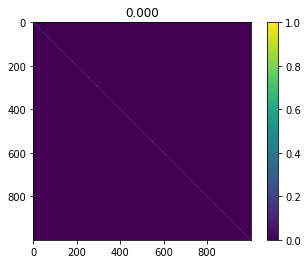

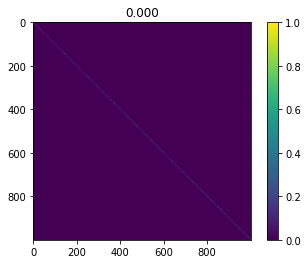

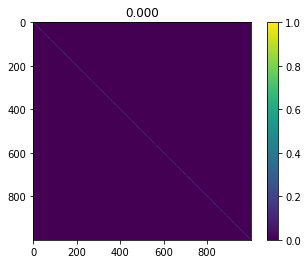

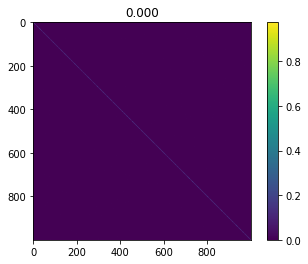

In [50]:
for irm in irms:
    H = irm @ irm.T
    err = mean_squared_error(y_train, H @ y_train)
    plt.imshow(H)
    plt.title(f'{err:.3f}')
    plt.colorbar()
    plt.show()
    break

In [93]:
# H_dfs = np.asarray([
#     [
#         df(irm @ irm.T @ np.diag(y_train[:, i]))
#         for i in range(len(np.unique(y_train, axis=0)))
#     ] for irm in irms
# ])

H_dfs = np.asarray([
    [
        df(irm @ irm.T @ np.sum([np.diag(y_train[:, i])
        for i in range(len(np.unique(y_train, axis=0)))], axis=0))
    ] for irm in irms
])

In [40]:
Hy1 = irms[7] @ irms[7].T @ np.diag(y_train[:, 0])
np.linalg.svd(Hy1, compute_uv=False)

array([1.00000000e+000, 9.09638843e-001, 8.72897811e-001, 8.64832153e-001,
       8.60629275e-001, 8.46672968e-001, 8.01093688e-001, 7.64282397e-001,
       7.28587766e-001, 7.25061942e-001, 7.01149440e-001, 6.96298193e-001,
       6.87609704e-001, 6.81505995e-001, 6.69910947e-001, 6.61960515e-001,
       6.58817327e-001, 6.35170083e-001, 6.29055816e-001, 6.24636692e-001,
       6.06602494e-001, 5.99059517e-001, 5.80249532e-001, 5.70415978e-001,
       5.58208402e-001, 5.52239138e-001, 5.45478625e-001, 5.36044707e-001,
       5.32985024e-001, 5.24915513e-001, 5.15648585e-001, 5.08112589e-001,
       5.01086524e-001, 4.97675602e-001, 4.83068085e-001, 4.77309783e-001,
       4.73288247e-001, 4.62945686e-001, 4.54861774e-001, 4.45775723e-001,
       4.28286481e-001, 4.20901821e-001, 4.12059048e-001, 4.10161879e-001,
       4.01312659e-001, 3.98752737e-001, 3.91161773e-001, 3.84999785e-001,
       3.77101968e-001, 3.66422445e-001, 3.59478137e-001, 3.58226137e-001,
       3.37195641e-001, 3

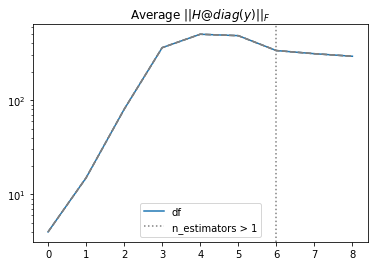

In [94]:
# H diag(y) norm
plt.plot(np.arange(len(H_dfs)), np.mean(H_dfs, axis=1), label='df')
plt.plot(np.arange(len(H_dfs)), np.mean(H_dfs, axis=1) + 2*np.sqrt(np.var(H_dfs, axis=1)), ls='--', c='grey')
plt.plot(np.arange(len(H_dfs)), np.mean(H_dfs, axis=1) - 2*np.sqrt(np.var(H_dfs, axis=1)), ls='--', c='grey')
plt.axvline(6, ls=':', c='grey', label='n_estimators > 1')
plt.yscale('log')
plt.legend()
plt.title(r'Average $||H @ diag(y)||_F$')
plt.show()

In [103]:
M_dfs = np.asarray([
    [
        df(np.ceil(M) @ W.T / W.shape[0]) # ceil to un_scale IRM columns
        for W in Ws
    ] for M, Ws in zip(irms, weights)
])

In [10]:
M = irms[0]
Hy = M @ M.T @ np.diag(y_train[:, 0])

W = weights[0][0]
MW = np.ceil(M) @ W.T

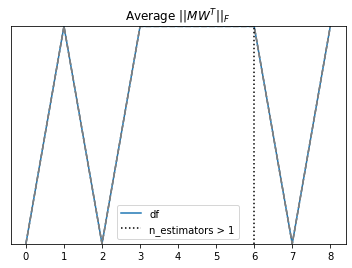

In [104]:
# H diag(y) norm
plt.plot(np.arange(len(M_dfs)), np.mean(M_dfs, axis=1), label='df')
plt.plot(np.arange(len(M_dfs)), np.mean(M_dfs, axis=1) + 2*np.sqrt(np.var(M_dfs, axis=1)), ls='--', c='grey')
plt.plot(np.arange(len(M_dfs)), np.mean(M_dfs, axis=1) - 2*np.sqrt(np.var(M_dfs, axis=1)), ls='--', c='grey')
plt.axvline(6, ls=':', c='black', label='n_estimators > 1')
plt.yscale('log')
plt.legend()
plt.title(r'Average $||MW^T||_F$')
plt.show()

In [106]:
M_dfs

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [102]:
M_dfs[-6]

array([0.0955    , 0.10229064, 0.08745905, 0.07670977, 0.09111726,
       0.08422549, 0.0846381 , 0.1044006 , 0.07670315, 0.0825187 ])

## NN "hat" matrix

In [2]:
from partition_decode.models import ReluNetClassifier, ReluNetRegressor
import torch

In [4]:
X_train, y_train = load_mnist(
    random_state=1,
    train=True,
    n_samples=1000,
    save_path="/mnt/ssd3/ronan/pytorch",
    onehot=True
)

X_test, y_test = load_mnist(
    random_state=1234,
    train=False,
    n_samples=10000,
    save_path="/mnt/ssd3/ronan/pytorch",
    onehot=True
)

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [ ]:
widths = [10, 13, 15, 17, 20, 30, 128]
gen_errors = []
irms = []
weights = []
train_errors = []
test_errors = []

prior_model = None
for n_hidden in widths:
    print(n_hidden, end=', ')
    model = ReluNetRegressor(
        verbose=0, n_epochs=1000, hidden_layer_dims=[n_hidden], batch_size=32,
        learning_rate=0.01, early_stop_thresh=0, bias=True)
    if prior_model is None or n_hidden > 100:
        model = model.fit(X_train, y_train)
    else:
        model._build_model(X_train.shape[-1], y_train.shape[1])
        with torch.no_grad():
            for prior_layer, new_layer in zip(prior_model.model_, model.model_,):
                if isinstance(new_layer, torch.nn.ReLU):
                    continue
                width, depth = prior_layer.weight.shape
                new_layer.weight[:width, :depth] = prior_layer.weight
                new_layer.bias[:width] = prior_layer.bias
        model._train_model(X_train, y_train)

    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)

    # train_errors.append(mean_squared_error(y_train, y_train_hat))
    # test_errors.append(mean_squared_error(y_test, y_test_hat))
    
    train_errors.append(zero_one_loss(y_train.argmax(1), y_train_hat.argmax(1)))
    test_errors.append(zero_one_loss(y_test.argmax(1), y_test_hat.argmax(1)))
    
    gen_errors.append(test_errors[-1] - train_errors[-1])
    irms.append(model.get_internal_representation(X_train))
    W, b, _ = model.get_affine_functions()
    weights.append(np.concatenate((b.reshape(*b.shape, 1), W), axis=-1))
    
    prior_model = model

10, 13, 15, 17, 

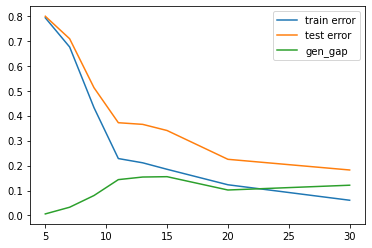

In [37]:
plt.plot(widths, train_errors, label='train error')
plt.plot(widths, test_errors, label='test error')
plt.plot(widths, gen_errors, label='gen_gap')
plt.legend()
# plt.yscale('symlog')
# plt.xscale('log')
plt.show()

In [17]:
(irms[0] @ weights[0][0]).shape

(1000, 785)

In [30]:
M_dfs = np.asarray([
    [
        df(M @ W, p=2) # ceil to un_scale IRM columns
        for W in Ws
    ] for M, Ws in zip(irms, weights)
])

In [31]:
M_dfs[0]

array([369.81477378, 107.81142635,  55.76360611, 107.58527893,
       213.13747191, 141.95653616,  35.30191606, 328.1478327 ,
       110.34250153, 188.85500145])

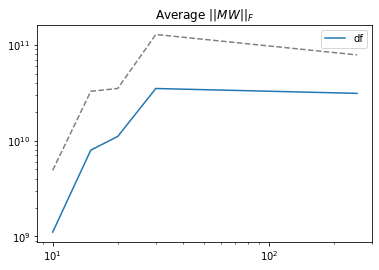

In [28]:
# H diag(y) norm
plt.plot(widths, np.mean(M_dfs, axis=1), label='df')
plt.plot(widths, np.mean(M_dfs, axis=1) + 2*np.sqrt(np.var(M_dfs, axis=1)), ls='--', c='grey')
plt.plot(widths, np.mean(M_dfs, axis=1) - 2*np.sqrt(np.var(M_dfs, axis=1)), ls='--', c='grey')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(r'Average $||MW||_F$')
plt.show()

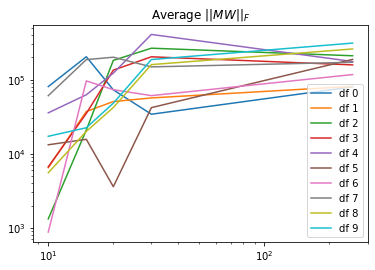

In [22]:
# H diag(y) norm
for i in range(10):
    plt.plot(widths, M_dfs[:, i], label=f'df {i}')
# plt.plot(widths, np.mean(M_dfs, axis=1) + 2*np.sqrt(np.var(M_dfs, axis=1)), ls='--', c='grey')
# plt.plot(widths, np.mean(M_dfs, axis=1) - 2*np.sqrt(np.var(M_dfs, axis=1)), ls='--', c='grey')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(r'Average $||MW||_F$')
plt.show()